In [3]:
import matplotlib.pyplot as plt
import calplot
import calmap
import csv
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import os
from nltk.corpus import words 
from IPython.display import HTML, display
from datasketch import MinHash, MinHashLSH
import pandas as pd
from sklearn.model_selection import train_test_split
from datasketch import MinHash, MinHashLSH

<h2>Overview of the data and data source.</h2> 

This dataset contains and excert of Spam and Ham E-Mails from the Enron Corpus. 

Enron was an american company, that due to financial fraud collapse and subsequentiall was under investigation by law enforcement agencies. During these investigations, E-Mails servers were seized and later published. 

Today this corpus is special, as it is only one of the few datsets, that actually contain 'real' E-Mails ready for analysis. 

The entire Corpus is around 600000 E-Mails, for this project a smaller subset is being used for Spam detection. 

<h2>Goals of the project</h2>

The goal of the project is to analyze different Spam. Several goals: 

1. Find the best Spam filter
2. Determine which effect on the Spam recognition the Subject line has. 
3. Determine the best Dataset for Spam detection out of a number of datasets --> e.g. train with 5 datasets and test on 6 dataset

<h2>Analyzing and Understanding the Dataset</h2<

In [4]:
data_file = './enron_spam_data.csv'

In [5]:
enron_df = pd.read_csv(data_file)

In [6]:
enron_df_original = pd.read_csv(data_file)

In [7]:
header_names = enron_df.keys()

In [8]:
print(header_names)

Index(['Message ID', 'Subject', 'Message', 'Spam/Ham', 'Date'], dtype='object')


In [9]:
enron_df.head()

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14


In [10]:
enron_df.describe()

,Message ID
count,33716.000000
mean,16857.500000
std,9733.115174
min,0.000000
25%,8428.750000
50%,16857.500000
75%,25286.250000
max,33715.000000


<h2>Data distribution</h2>

In [11]:
enron_label = enron_df['Spam/Ham'].value_counts()
print(enron_label)

spam    17171
ham     16545
Name: Spam/Ham, dtype: int64


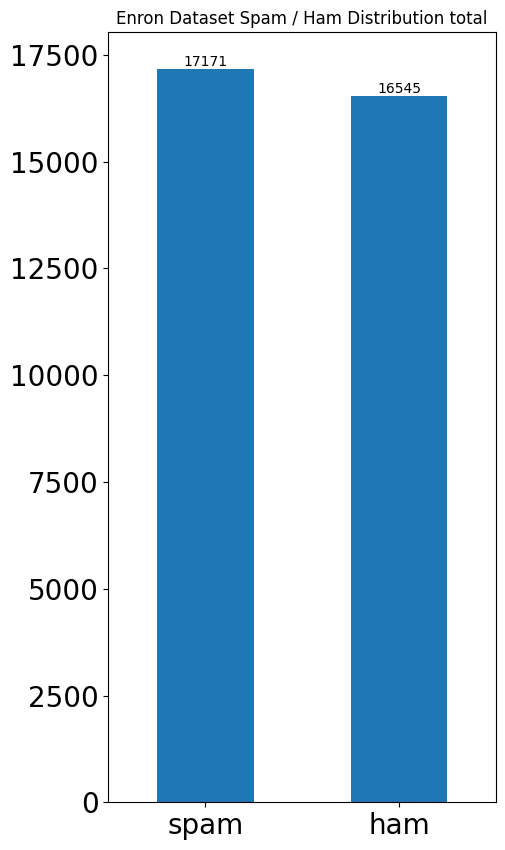

In [12]:
ax = enron_label.plot(kind='bar', figsize=(5,10), fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
for i in ax.containers:
    ax.bar_label(i, label_type='edge')
ax.set_title('Enron Dataset Spam / Ham Distribution total')
plt.show()

In [13]:
enron_percentage = (enron_df['Spam/Ham'].value_counts(normalize=True))*100
print(enron_percentage)

spam    50.928343
ham     49.071657
Name: Spam/Ham, dtype: float64


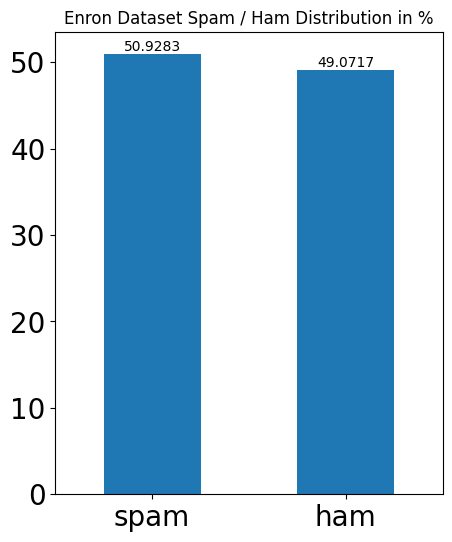

In [14]:
ax = enron_percentage.plot(kind='bar', figsize=(5,6), fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
for i in ax.containers:
    ax.bar_label(i, label_type='edge')
ax.set_title('Enron Dataset Spam / Ham Distribution in %')
plt.show()

<h2>Data Cleaning and Data Preparation</h2>

Noticing the NaN in the first message shown above, I decided to anayze how complete the dataset is. 

In [15]:
messageID_NaN = enron_df['Message ID'].isna().sum()
subject_NaN = enron_df['Subject'].isna().sum()
message_NaN = enron_df['Message'].isna().sum()
spam_NaN = enron_df['Spam/Ham'].isna().sum()
print(f"Number of NaN values in 'Message ID' column: {messageID_NaN}")
print(f"Number of NaN values in 'Subject' column: {subject_NaN}")
print(f"Number of NaN values in 'Message' column: {message_NaN}")
print(f"Number of NaN values in 'Spam/Ham' column: {spam_NaN}")

Number of NaN values in 'Message ID' column: 0
Number of NaN values in 'Subject' column: 289
Number of NaN values in 'Message' column: 371
Number of NaN values in 'Spam/Ham' column: 0


In [16]:
max_nan = subject_NaN + message_NaN
percentage_nan = max_nan / len(enron_df)
print('Total Maximum Lost E-Mails:' ,max_nan)
print('Percentage of Total E-Mails:',percentage_nan)

Total Maximum Lost E-Mails: 660
Percentage of Total E-Mails: 0.019575275833432198


As we can see, a maximum of 660 E-Mails would be lost if we dropped all NaN values. While this is only 1,9% of all E-Mails, we risk eleminating Spam messages and tainting the analysis. Therefore I analyze how many of the 'subjectless' E-Mails are Spam.

In [17]:
na_and_spam_sub = len(enron_df[(enron_df["Subject"].isna()) & (enron_df["Spam/Ham"]=='spam')])
na_and_spam_mes = len(enron_df[(enron_df["Message"].isna()) & (enron_df["Spam/Ham"]=='spam')])
print('Subject = NaN && is Spam:',na_and_spam_sub)
print('Message = NaN && is spam:' ,na_and_spam_mes)

Subject = NaN && is Spam: 289
Message = NaN && is spam: 319


Interestingly enough, all of the message where there is no subject are classified as Spam.
For Messages with no Body, this happens also for most of the messages

In [18]:
print(enron_df[enron_df['Subject'].isna()])

       Message ID Subject                                            Message  \
3699         3699     NaN  holiday specials on : didrex and nasacort\n60 ...   
3708         3708     NaN  the only solution to penis\nenlargement\nnzzbq...   
3749         3749     NaN                                                NaN   
3777         3777     NaN  to _ cc _ default _ handler\nsubject : [ spam ...   
3820         3820     NaN  discount meds right from home\nvalium , xanax ...   
...           ...     ...                                                ...   
32833       32833     NaN  why paily for pobrne ?\nas a lrpim " itecd ti ...   
32835       32835     NaN  are youu stil 3 l pa margin - right : 8 " alig...   
32898       32898     NaN  pre - ejeculators :\nplease read here for info...   
32926       32926     NaN  there ' s never been a better time to re _ fin...   
33155       33155     NaN  sud euler gangling phoneme billy birdlike dutc...   

      Spam/Ham        Date  
3699      

Taking a quick peek at these couple of message, they indeed appear to be Spam. 

Let us now count the number of message where there is no subject line and no body: 

In [19]:
empty_message = len(enron_df[(enron_df["Subject"].isna()) & (enron_df["Message"].isna())])

In [20]:
print(empty_message)

51


In [21]:
print(enron_df[(enron_df["Subject"].isna()) & (enron_df["Message"].isna())])

       Message ID Subject Message Spam/Ham        Date
3749         3749     NaN     NaN     spam  2004-01-24
4062         4062     NaN     NaN     spam  2004-06-22
4136         4136     NaN     NaN     spam  2004-07-22
4141         4141     NaN     NaN     spam  2004-07-24
4153         4153     NaN     NaN     spam  2004-07-29
4254         4254     NaN     NaN     spam  2004-09-04
4282         4282     NaN     NaN     spam  2004-09-15
4593         4593     NaN     NaN     spam  2004-12-21
4596         4596     NaN     NaN     spam  2004-12-23
4601         4601     NaN     NaN     spam  2004-12-25
4683         4683     NaN     NaN     spam  2005-01-25
4684         4684     NaN     NaN     spam  2005-01-25
4691         4691     NaN     NaN     spam  2005-01-27
4706         4706     NaN     NaN     spam  2005-02-02
4728         4728     NaN     NaN     spam  2005-02-07
4963         4963     NaN     NaN     spam  2005-05-13
18420       18420     NaN     NaN     spam  2004-02-28
18581     

Indeed there are 51 message that do not contain Subject and Message. We will leave those in the dataframe, as they are nevertheless Spam. While they are probably not Harmful (maybe except for DoS against the server), they can be annoying for the enduser. 

As can be seen above, we notice the Column Date. While it is surely interesting to correlate the impending doom of financial collapse of the company to the amount of E-Mails send in that time frame, having the date for detecting Spams is not necessary. 

Potentially for later graphics it would be interesting to see, if Spam is sent on the weekend or not.

In any case, for now we can safely ignore the Date column: 

In [22]:
enron_df.drop('Date', axis=1, inplace = True)

In [23]:
df2 = enron_df[enron_df['Message'].duplicated() == True].sort_values('Message')

In [24]:
print(df2)

       Message ID                                            Subject  \
25239       25239                             how to soak her in cum   
25726       25726                             how to soak her in cum   
32524       32524  aggressive investors and traders shouid be wat...   
32508       32508      owning these shares fast - tracks performance   
32591       32591  this performer defines the secret of stock sel...   
...           ...                                                ...   
27999       27999                           ripley house photo album   
28722       28722  http : / / hrweb . enron . com / benefits / fo...   
29059       29059                          h : eyeforenergy briefing   
29100       29100                          h : eyeforenergy briefing   
29109       29109                                            website   

                                                 Message Spam/Ham  
25239  " i just wanted to write and thank you for spu...     spam  

Obviously if we consider the nature of Spam messages, it becomes clear that some of the received messages are Duplicates. I have decided to remove all of these duplicates, as we do not want to have any bias in the following analysis. 

In [25]:
enron_df.describe()

,Message ID
count,33716.000000
mean,16857.500000
std,9733.115174
min,0.000000
25%,8428.750000
50%,16857.500000
75%,25286.250000
max,33715.000000


In [26]:
enron_df.drop_duplicates(subset=['Message'], inplace = True)

In [27]:
enron_df.head()

,Message ID,Subject,Message,Spam/Ham
0,0,christmas tree farm pictures,NaN,ham
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham


In [28]:
enron_df.describe()

,Message ID
count,29780.000000
mean,16090.690262
std,9683.706508
min,0.000000
25%,7782.750000
50%,15597.500000
75%,23917.250000
max,33714.000000


In [29]:
df2 = len(enron_df[enron_df['Subject'].duplicated() == True])

In [30]:
print(df2)

6205


As we can see, there are also 6205 dubplicated subjects. This surprised me, as it represent a significant part of all the messages. Neverthless I decided to not remove those messages, as we have already remove messages.

As Python is casesensitive I have decided to transform all words into lowercase. Although it appears the dataset is already completly in lowercase, I do this for safety reasons.

In [31]:
enron_df['Message'] = enron_df['Message'].str.lower()
enron_df['Subject'] = enron_df['Subject'].str.lower()

In [32]:
enron_df.head()

,Message ID,Subject,Message,Spam/Ham
0,0,christmas tree farm pictures,NaN,ham
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham


In [33]:
enron_df["Message"] = enron_df['Message'].str.replace('[^\w\s]','', regex=True)
enron_df["Subject"] = enron_df['Subject'].str.replace('[^\w\s]','', regex=True)

In [34]:
enron_df.head()

,Message ID,Subject,Message,Spam/Ham
0,0,christmas tree farm pictures,NaN,ham
1,1,vastar resources inc,gary production from the high island larger b...,ham
2,2,calpine daily gas nomination,calpine daily gas nomination 1 doc,ham
3,3,re issue,fyi see note below already done \nstella\n ...,ham
4,4,meter 7268 nov allocation,fyi \n forwarded by lauri...,ham


In [35]:
stop = stopwords.words('english')
enron_df['Message'] = enron_df['Message'].fillna('')
enron_df['Subject'] = enron_df['Subject'].fillna('')

In [36]:
enron_df['Message'] = enron_df['Message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
enron_df['Subject'] = enron_df['Subject'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [37]:
enron_df.head()

,Message ID,Subject,Message,Spam/Ham
0,0,christmas tree farm pictures,,ham
1,1,vastar resources inc,gary production high island larger block 1 2 c...,ham
2,2,calpine daily gas nomination,calpine daily gas nomination 1 doc,ham
3,3,issue,fyi see note already done stella forwarded ste...,ham
4,4,meter 7268 nov allocation,fyi forwarded lauri allen hou ect 12 14 99 12 ...,ham


As we can see removing punctuation and stopwords works fine. Sadly as we can see, due to reasons the NaN values had to be replaced with NaN. #################Potentially fix this alter

Having thought about how to handle the subject line of the message, I decideded to view the subject line simply as a "Headline", and therefore decided to unfiy message and subject into one column. In a sense, this also solves our NaN problem, as it is now ensure that every anaylze E-Mail has a unified message we can look at. 

In [38]:
enron_df['unified'] = enron_df['Subject'] + ' ' + enron_df['Message']
enron_df_unified = enron_df.drop(['Subject', 'Message'], axis = 1)

In [39]:
enron_df.head()

,Message ID,Subject,Message,Spam/Ham,unified
0,0,christmas tree farm pictures,,ham,christmas tree farm pictures
1,1,vastar resources inc,gary production high island larger block 1 2 c...,ham,vastar resources inc gary production high isla...
2,2,calpine daily gas nomination,calpine daily gas nomination 1 doc,ham,calpine daily gas nomination calpine daily gas...
3,3,issue,fyi see note already done stella forwarded ste...,ham,issue fyi see note already done stella forward...
4,4,meter 7268 nov allocation,fyi forwarded lauri allen hou ect 12 14 99 12 ...,ham,meter 7268 nov allocation fyi forwarded lauri ...


In [55]:
enron_df_unified.head()

,Message ID,Spam/Ham,unified
0,0,ham,christmas tree farm pictures
1,1,ham,vastar resources inc gary production high isla...
2,2,ham,calpine daily gas nomination calpine daily gas...
3,3,ham,issue fyi see note already done stella forward...
4,4,ham,meter 7268 nov allocation fyi forwarded lauri ...


<h2>Analysis of cleaned data</h2>

<h3>Length of Spam / Ham messages</h3>

In [68]:
enron_df_spam = enron_df_unified[enron_df_unified["Spam/Ham"] == "spam"]
print("Length of the longest ham message is:", enron_df_spam.unified.str.len().max())

Length of the longest ham message is: 22726


In [69]:
enron_df_ham = enron_df_unified[enron_df_unified["Spam/Ham"] == "ham"]
print("Length of the longest spam message is:", enron_df_ham.unified.str.len().max())

Length of the longest spam message is: 160324


In [70]:
print("Length of the mean spam message is:", round(enron_df_spam.unified.str.len().mean(),2 ))

Length of the mean spam message is: 968.33


In [71]:
print("Length of the mean ham message is:", round(enron_df_ham.unified.str.len().mean(),2))

Length of the mean ham message is: 1116.71


<h2>Distribution of Spam Message Length</h2>

In [97]:
# Define the bin edges for the message lengths
bin_edges = range(0, 2501, 100)

# Bin the message lengths into different ranges using the cut method
bin_labels = ["{}-{}".format(start, end) for start, end in zip(bin_edges[:-1], bin_edges[1:])]
enron_df_spam.loc[:, "length_range"] = pd.cut(enron_df_spam["unified"].str.len(), bins=bin_edges, labels=bin_labels)

/tmp/ipykernel_8476/2145000043.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enron_df_spam.loc[:, "length_range"] = pd.cut(enron_df_spam["unified"].str.len(), bins=bin_edges, labels=bin_labels)
/tmp/ipykernel_8476/2145000043.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  enron_df_spam.loc[:, "length_range"] = pd.cut(enron_df_spam["unified"].str.len(), bins=bin_edges, labels=bin_labels)


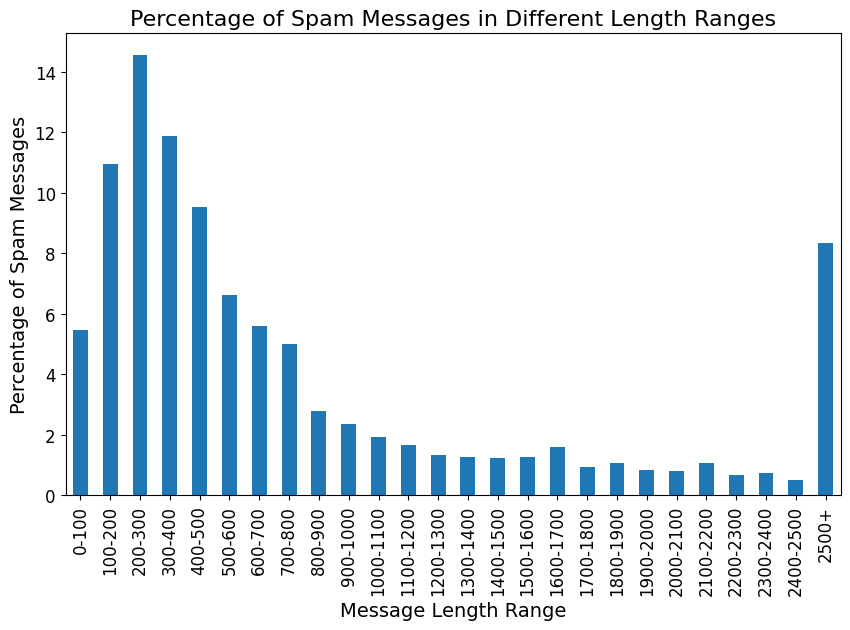

In [99]:
length_counts = enron_df_spam["length_range"].value_counts()

# Divide by the total number of spam messages to get the percentage
length_percents = length_counts / len(enron_df_spam) * 100

# Sort the length_percents Series by its index
length_percents_sorted = length_percents.sort_index()
length_percents_sorted["2500+"] = (enron_df_spam["unified"].str.len() > 2500).sum() / len(enron_df_spam) * 100
length_percents_sorted.plot(kind="bar", rot=90, figsize=(10, 6), fontsize=12)
plt.xlabel("Spam Message Length Range", fontsize=14)
plt.ylabel("Percentage of Spam Messages", fontsize=14)
plt.title("Percentage of Spam Messages in Different Length Ranges", fontsize=16)
plt.show()

In [102]:
# Define the bin edges for the message lengths
bin_edges = range(0, 2501, 100)

# Bin the message lengths into different ranges using the cut method
bin_labels = ["{}-{}".format(start, end) for start, end in zip(bin_edges[:-1], bin_edges[1:])]
enron_df_ham.loc[:, "length_range"] = pd.cut(enron_df_ham["unified"].str.len(), bins=bin_edges, labels=bin_labels)

/tmp/ipykernel_8476/511611452.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enron_df_ham.loc[:, "length_range"] = pd.cut(enron_df_ham["unified"].str.len(), bins=bin_edges, labels=bin_labels)
/tmp/ipykernel_8476/511611452.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  enron_df_ham.loc[:, "length_range"] = pd.cut(enron_df_ham["unified"].str.len(), bins=bin_edges, labels=bin_labels)


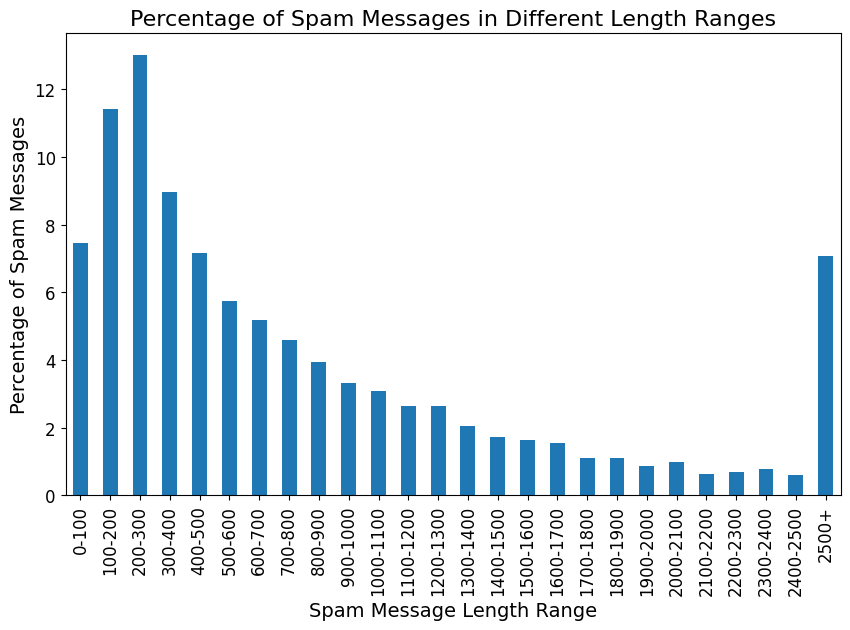

In [103]:
length_counts = enron_df_ham["length_range"].value_counts()

# Divide by the total number of spam messages to get the percentage
length_percents = length_counts / len(enron_df_ham) * 100

# Sort the length_percents Series by its index
length_percents_sorted = length_percents.sort_index()
length_percents_sorted["2500+"] = (enron_df_ham["unified"].str.len() > 2500).sum() / len(enron_df_ham) * 100
length_percents_sorted.plot(kind="bar", rot=90, figsize=(10, 6), fontsize=12)
plt.xlabel("Spam Message Length Range", fontsize=14)
plt.ylabel("Percentage of Spam Messages", fontsize=14)
plt.title("Percentage of Spam Messages in Different Length Ranges", fontsize=16)
plt.show()

<h3>Wordcloud</h3>

In [ ]:
na_rows = enron_df_unified[enron_df_unified['Spam/Ham'].isna() | (enron_df_unified['Spam/Ham'] == ' ')]
print(na_rows)

As a last step, I decide to randomlay arrange the order of rows, so there is no bias: 

In [ ]:
enron_df_unified = enron_df_unified.sample(frac=1)

In [ ]:
enron_df_nb = enron_df_unified.copy()
enron_df_bl = enron_df_unified.copy()
enron_df_lsh = enron_df_unified.copy()

At this point, our dataframe is ready to be analyzed. We can begin with the training using the enron_df_uniied df. 

<h2>Naive Bayes Filter</h2>

We will start with the Naive Bayes Filter. In this stage we start to analyze firstly our unified version of the subject and the E-Mail body. 

Later we take a look how well this Bayes Filter works, when we analyze the Subject Line and the E-Mail body separatly.

Lastly I use a different way to implement the Bayes Filter that I found online: the description can be found here: https://www.kdnuggets.com/2020/07/spam-filter-python-naive-bayes-scratch.html

In [ ]:
training_ratio = 0.7

<h3>Unified Subject Line and E-Mail Body</h3>

In [ ]:
X_unified = enron_df_nb['unified']
y_unified = enron_df_nb['Spam/Ham']
X_train, X_test, y_train, y_test, idx_train, idx_test = \
    train_test_split(X_unified, y_unified, range(len(y_unified)), 
    train_size=training_ratio, random_state=1)

vectorizer = CountVectorizer()
X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.transform(X_test)

mnb = MultinomialNB()
mnb.fit(X_train_vector, y_train)
y_pred = mnb.predict(X_test_vector)

results_df = pd.concat([y_test.reset_index(drop=True), pd.Series(y_pred)], axis=1, keys=['true', 'predicted'])

print(classification_report(y_test, y_pred, target_names=['Spam', 'Ham']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))

In [ ]:
wrong_predictions = 0
for i, row in results_df.iterrows():
    if row['true'] != row['predicted']:
        print(f"Predicted: {row['predicted']}, True: {row['true']},\nText: {X_test.iloc[i]}\n")
        wrong_predictions += 1

In [ ]:
print(f"Number of wrong predictions: {wrong_predictions}")

<h1>#########NOTE: NEED TO ANALYZE THIS NOW</h1>

<h3>Analyzing only the subject line</h3>

Let us now try to analyze what happens if we only observe the Subject headers. How does this affect the Spam detection accuracy?

My suspicion is, that this will lower the recognition rate of Spam significantly. I even suspect it will make the Spam Filter completly worthless, with possible prediction rates approach 60% or less.

In [ ]:
subject_NaN = enron_df['Subject'].isna().sum()
subject_empty = (enron_df['Subject'] == ' ').sum()

print(subject_NaN)
print(subject_empty)

In [ ]:
X_subject = enron_df['Subject']
y_subject = enron_df['Spam/Ham']
X_train, X_test, y_train, y_test, idx_train, idx_test = \
    train_test_split(X_subject, y_subject, range(len(y_unified)), 
    train_size=training_ratio, random_state=1)

vectorizer = CountVectorizer()
X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.transform(X_test)

mnb = MultinomialNB()
mnb.fit(X_train_vector, y_train)
y_pred = mnb.predict(X_test_vector)

results_df = pd.concat([y_test.reset_index(drop=True), pd.Series(y_pred)], axis=1, keys=['true', 'predicted'])

print(classification_report(y_test, y_pred, target_names=['Spam', 'Ham']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))

As we can see, even when only anayzing the subject line it can still reach a correct predicition of 90.3%, which is not great but still much better than expected. Still quite useless though and it confirms the suspicion that only using the Subject Line to analyze Spam is definitly not enough.

In [ ]:
wrong_predictions = 0
for i, row in results_df.iterrows():
    if row['true'] != row['predicted']:
        print(f"Predicted: {row['predicted']}, True: {row['true']},\nText: {X_test.iloc[i]}\n")
        wrong_predictions += 1

In [ ]:
print(f"Number of wrong predictions: {wrong_predictions}")

<h3>Analyzing only the E-Mail Body</h3>

Now lets try the same with only the message body and see how much effect the Subject has on the Spam detection. 

In [ ]:
X_body = enron_df['Message']
y_body = enron_df['Spam/Ham']
X_train, X_test, y_train, y_test, idx_train, idx_test = \
    train_test_split(X_body, y_body, range(len(y_unified)), 
    train_size=training_ratio, random_state=1)

vectorizer = CountVectorizer()
X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.transform(X_test)

mnb = MultinomialNB()
mnb.fit(X_train_vector, y_train)
y_pred = mnb.predict(X_test_vector)

results_df = pd.concat([y_test.reset_index(drop=True), pd.Series(y_pred)], axis=1, keys=['true', 'predicted'])

print(classification_report(y_test, y_pred, target_names=['Spam', 'Ham']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))

It has 98.4%! This is quite good. But still less than the unification of the body and the Subject. Therefore it makes sense to use the first method which unfies both Subject Line and E-Mail body. 

For future analysis and representation, only the first analysis type will be considered

<h2>############### TO DO Blacklisting --> Need to randomize order of files</h2>

In [ ]:
X_train_bl = enron_df_bl[:int(len(enron_df_bl)*training_ratio)]
X_test_bl = enron_df_bl[int(len(enron_df_bl)*training_ratio):]
x_train_Spam_bl = enron_df_bl['Spam/Ham']
stemmer = nltk.PorterStemmer()
stopwords = set(nltk.corpus.stopwords.words('english'))
spam_words = set()
ham_words = set()


for _, row in X_train_bl.iterrows():
    path = row['unified']
    label = row['Spam/Ham']
    tokens = nltk.word_tokenize(path)
    if len(tokens) > 2:
        stems = [stemmer.stem(w) for w in tokens if w not in stopwords]
    if not stems:
        continue
    if label == 'ham':
        ham_words.update(stems)
    elif label == 'spam':
        spam_words.update(stems)
    else:
        continue

blacklist = spam_words - ham_words
pickle.dump(blacklist, open('blacklist.pkl', 'wb'))

print(len(spam_words))
print(len(ham_words))
print('Blacklist of {} tokens successfully built/loaded'.format(len(blacklist)))

In [ ]:
word_set = set(words.words()) 
word_set.intersection(blacklist)

In [ ]:
fp = 0
tp = 0
fn = 0
tn = 0

for _, row in X_test_bl.iterrows():
    path = row['unified']
    label = row['Spam/Ham']
    tokens = nltk.word_tokenize(path)
    if len(tokens) > 2:
        stems = [stemmer.stem(w) for w in tokens if w not in stopwords]
    if not stems:
        continue
    stems_set = set(stems)
    if stems_set & blacklist: # email's words are in blacklist
        if label == 'ham': # ham
            fp = fp + 1 
        else:
            tp = tp + 1
    else: # email's words are not in blacklist
        if label == 'ham':
            tn = tn + 1
        else:
            fn = fn + 1

In [ ]:
conf_matrix = [[tn, fp],
               [fn, tp]]
display(HTML('<table><tr>{}</tr></table>'.format(
    '</tr><tr>'.join('<td>{}</td>'.format(
        '</td><td>'.join(str(_) for _ in row)) 
                     for row in conf_matrix))))

In [ ]:
count = tn + tp + fn + fp
percent_matrix = [["{:.1%}".format(tn/count), "{:.1%}".format(fp/count)],
                  ["{:.1%}".format(fn/count), "{:.1%}".format(tp/count)]]
display(HTML('<table><tr>{}</tr></table>'.format(
    '</tr><tr>'.join('<td>{}</td>'.format(
        '</td><td>'.join(str(_) for _ in row)) 
                     for row in percent_matrix))))

In [ ]:
print("Classification accuracy: {}".format("{:.1%}".format((tp+tn)/count)))

<h2>LSH ####################### fix classification accuracy</h2>

In [ ]:
X_train_lsh = enron_df_lsh[:int(len(enron_df_lsh)*training_ratio)]
X_test_lsh = enron_df_lsh[int(len(enron_df_lsh)*training_ratio):]
X_spam_files = X_train_lsh[X_train_lsh['Spam/Ham'] == 'spam']

In [ ]:
X_spam_files.head()

In [ ]:
lsh = MinHashLSH(threshold=0.5, num_perm=128)

In [ ]:
for idx, row in X_spam_files.iterrows():
    minhash = MinHash(num_perm=128)
    path = row['unified']
    tokens = nltk.word_tokenize(path)
    stems = [stemmer.stem(w) for w in tokens if w not in stopwords]
    if len(stems) < 2: continue
    for s in stems:
        minhash.update(s.encode('utf-8'))
    key = str(row['Message ID'])
    lsh.insert(key, minhash)

In [ ]:
def lsh_predict_label(stems):
    '''
    Queries the LSH matcher and returns:
        'spam' if predicted spam
        'ham' if predicted ham
       -1 if parsing error
    '''
    minhash = MinHash(num_perm=128)
    if len(stems) < 2:
        return -1
    for s in stems:
        minhash.update(s.encode('utf-8'))
    matches = lsh.query(minhash)
    if matches:
        return 'spam'
    else:
        return 'ham'

In [ ]:
fp = 0
tp = 0
fn = 0
tn = 0
false_negatives = []
true_negatives = []
false_positives = []
true_positives = []

for f, row in X_test_lsh.iterrows():
    label = row['Spam/Ham']
    path = row['unified']
    message_id = row['Message ID']
    tokens = nltk.word_tokenize(path)
    if not tokens:
        continue
    stems = [stemmer.stem(w) for w in tokens if w not in stopwords]
    if not stems:
        continue
    pred = lsh_predict_label(stems)
    if pred == -1:
        continue
    elif pred == 'spam': # predicted spam
        if label == 'ham':
            fp = fp + 1
            false_positives.append((message_id, pred, label, path))
        else:
            tp = tp + 1
            true_positives.append((message_id, pred, label, path))
    elif pred == 'ham': # predicted ham
        if label == 'ham':
            tn = tn + 1
            if(len(true_negatives) < 50):
                true_negatives.append((message_id, pred, label, path))
        else:
            fn = fn + 1
            if(len(false_negatives) < 20):
                false_negatives.append((message_id, pred, label, path))

In [ ]:
from IPython.display import HTML, display
conf_matrix = [[tn, fp],
               [fn, tp]]
display(HTML('<table><tr>{}</tr></table>'.format(
    '</tr><tr>'.join('<td>{}</td>'.format(
        '</td><td>'.join(str(_) for _ in row)) 
                     for row in conf_matrix))))

In [ ]:
count = tn + tp + fn + fp
percent_matrix = [["{:.1%}".format(tn/count), "{:.1%}".format(fp/count)],
                  ["{:.1%}".format(fn/count), "{:.1%}".format(tp/count)]]
display(HTML('<table><tr>{}</tr></table>'.format(
    '</tr><tr>'.join('<td>{}</td>'.format(
        '</td><td>'.join(str(_) for _ in row)) 
                     for row in percent_matrix))))

In [ ]:
print("Classification accuracy: {}".format("{:.1%}".format((tp+tn)/count)))

In [ ]:
print(X_test_lsh[X_test_lsh['Message ID'] == 13980])